In [ ]:
import math

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
N_LAYERS = 6
EMBEDDING_DIM = 384
HIDDEN_DIM = 4 * EMBEDDING_DIM
N_HEADS = 6
DROPOUT = 0.15
LEARNING_RATE = 3E-4
VOCAB_SIZE = 16384
CONTEXT_LENGTH = 128
BATCH_SIZE = 64
MAX_ITERS = 2000
EVAL_ITERS = 200

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

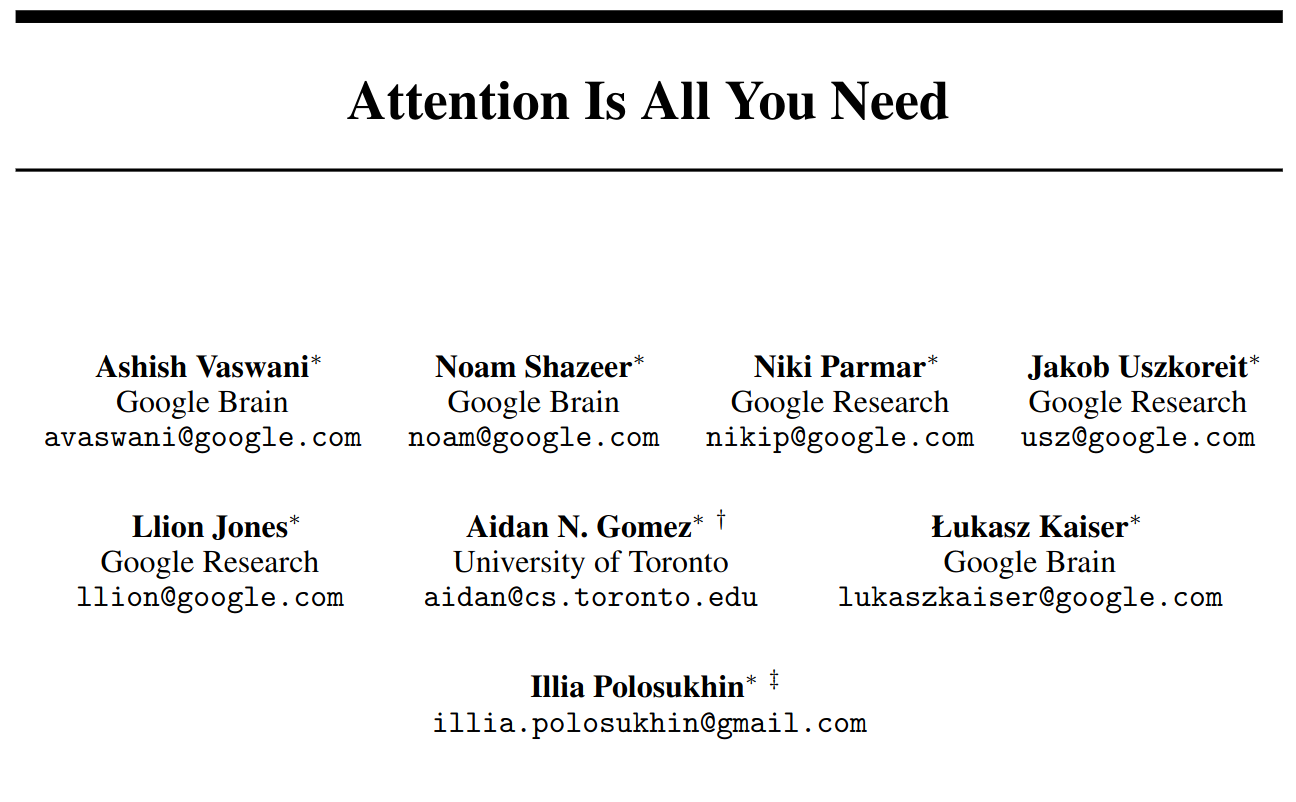

# Why attention?

inherent for animals

Can you find a man with red white striped shirt?

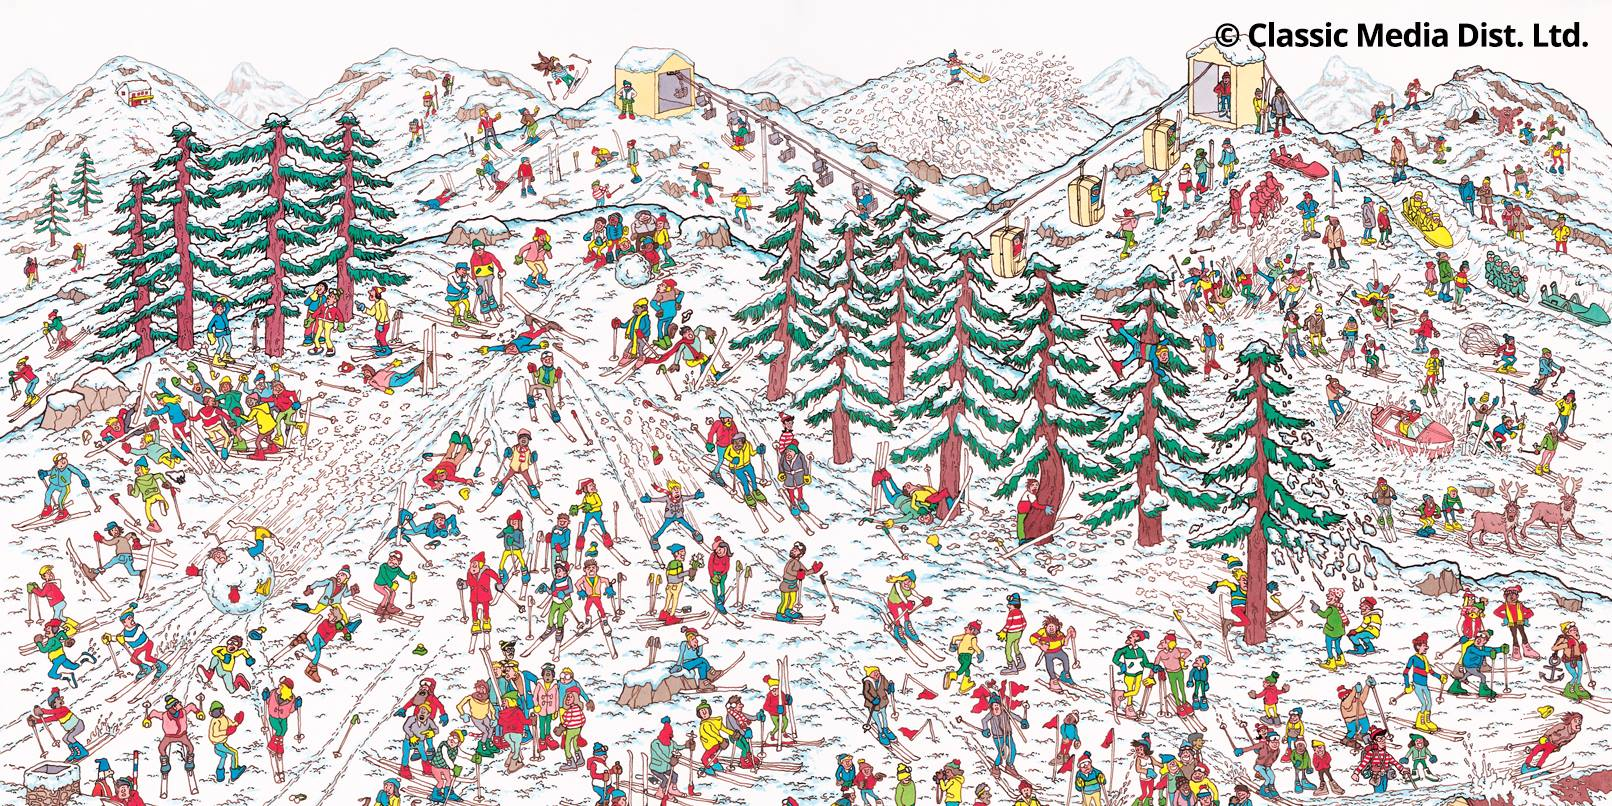

how about now?

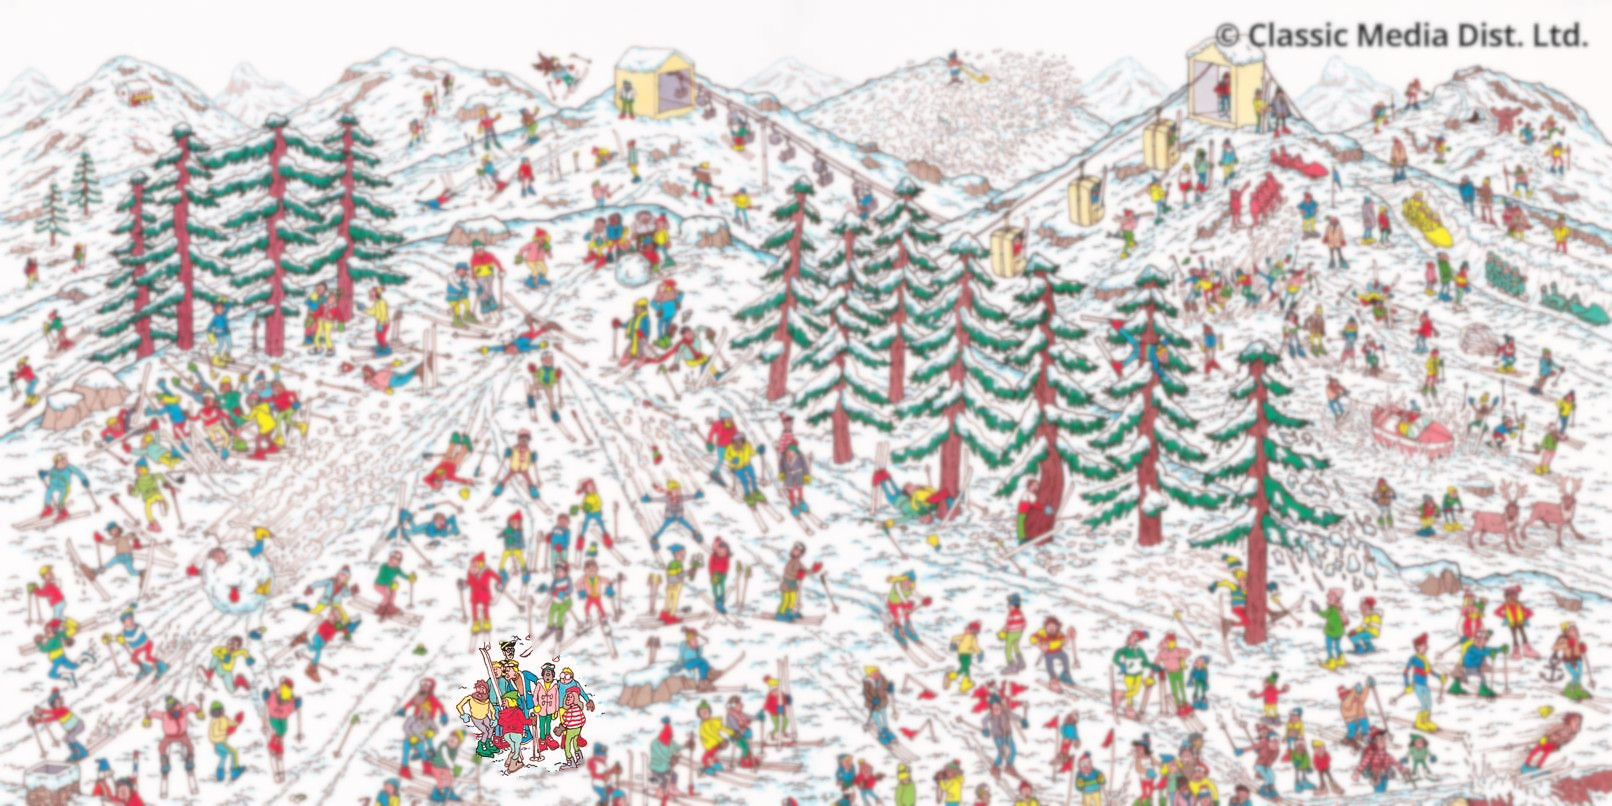

And now?
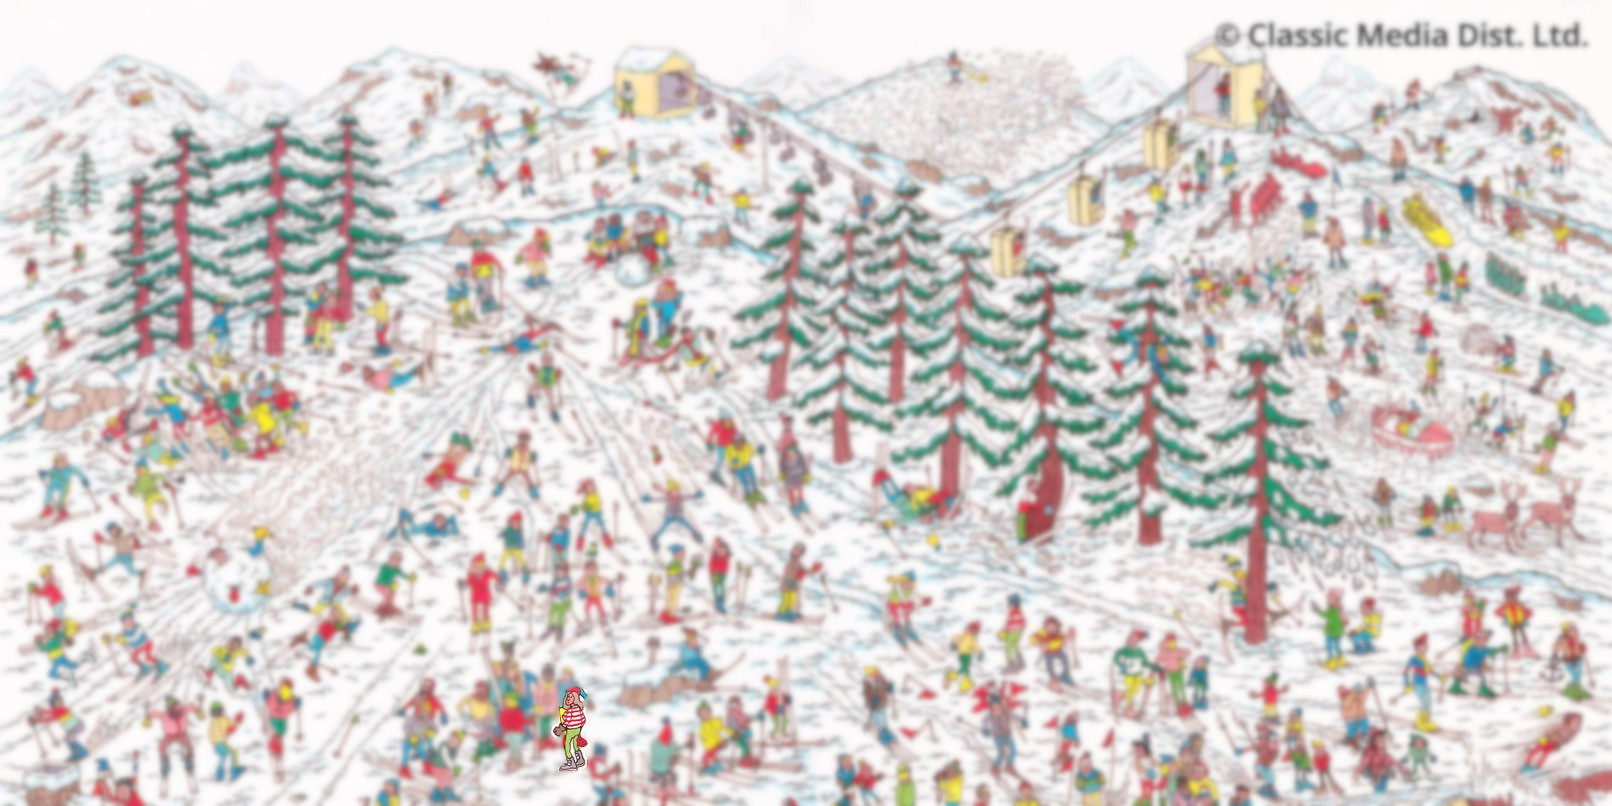

You can see it is easier to find the man in the third one then in the first one.

But why?

Because there is a attention on it, ignoring or reducing all not useful information

# Attention as soft dict

## how python dict works? (also called hard dict)

In [ ]:
data = {'A': 1, 'C': 2}
query = 'C'

keys = list(data.keys())
values = list(data.values())

print('Query: ', query, '\nKeys:  ', keys, '\nValues:', values)

Query:  C 
Keys:   ['A', 'C'] 
Values: [1, 2]


In [ ]:
data[query]

2

The result of the query 'C' in a dict with keys ['A', 'C'] is just the value of the key 'C'.

But what if I try to query 'B'?

In [ ]:
try:
    query = 'B'
    data[query]
except Exception as e:
    print(type(e))

<class 'KeyError'>


The hard dict does not allow queries that are not explicitly presented as keys.

How could we reformulate a dictionary that allows queries that are not in the keys?

```python
query = 'B'
data[query]
```
**posible answer**:

Use a similarity notion between the query and keys and return the weighted average between its values

For instance,
```python
Query:  'B'
Keys:   ['A', 'C']
Values: [1, 2]
```
'B' is exactly between 'A' and 'C', so one can say:

'B' is 0.5 of 'A' and 0.5 of 'C'
and return the weighted average:
```python
data['B'] = 0.5 * data['A'] + 0.5 * data['C']
```
i.e.
```python
data['B'] = 0.5 * 1 + 0.5 * 3
data['B'] = 1.5
```


In [ ]:
data['B'] = 0.5 * data['A'] + 0.5 * data['C']
data['B']

1.5

## Implementing attention as a soft dict

Assuming query, keys and values as vectors,
one can implement:

In [ ]:
def attention_as_soft_dict(query, keys, values):
    weights = query @ keys.T  # kinda similarity between query and keys
    weights = F.softmax(weights, dim=-1)  # normalize weights to sum 1
    return weights @ values  # values weighted average

In [ ]:
keys = torch.tensor([[1.,0],[0, 1.]])
values = torch.tensor([[1., 0], [0, 1.]])
query = torch.tensor([[1., 0.]])

attention_as_soft_dict(query, keys, values)

tensor([[0.7311, 0.2689]])

## Scaled dot product attention

### Why do I need to scale?

In [ ]:
def tabulate_multiplication_mean_and_var(*tensors):
    multiplication = tensors[0] @ tensors[1]
    scaled_multiplication = multiplication / math.sqrt(tensors[0].shape[-1])
    tensors = [*tensors, multiplication, scaled_multiplication]
    return pd.DataFrame(data=[[tensor.mean().item(), tensor.var().item()]
                              for tensor in tensors],
                        columns=['mean', 'variance'],
                        index=['a', 'b', 'a @ b', 'a @ b / sqrt(d)'])


a = torch.randn(size=(10, 10))
b = torch.randn(size=(10, 10))

tabulate_multiplication_mean_and_var(a, b)

,mean,variance
a,0.183934,0.567983
b,0.085248,1.328079
a @ b,0.188607,9.407702
a @ b / sqrt(d),0.059643,0.940770


It is possible to see that the variance of multiplication grows but it is not the same for its scaled version.

But What is its high variance impact in the softmax function?

In [ ]:
a = torch.tensor([0.1, 0.2, 0.7])
b = 100 * a

print('Softmax a:', F.softmax(a, dim=-1), '\nSoftmax b:',F.softmax(b, dim=-1))

Softmax a: tensor([0.2546, 0.2814, 0.4640]) 
Softmax b: tensor([8.7565e-27, 1.9287e-22, 1.0000e+00])


For greater values, the function tends to 1, so all other values, even if proportionally equal are reduced to zero.

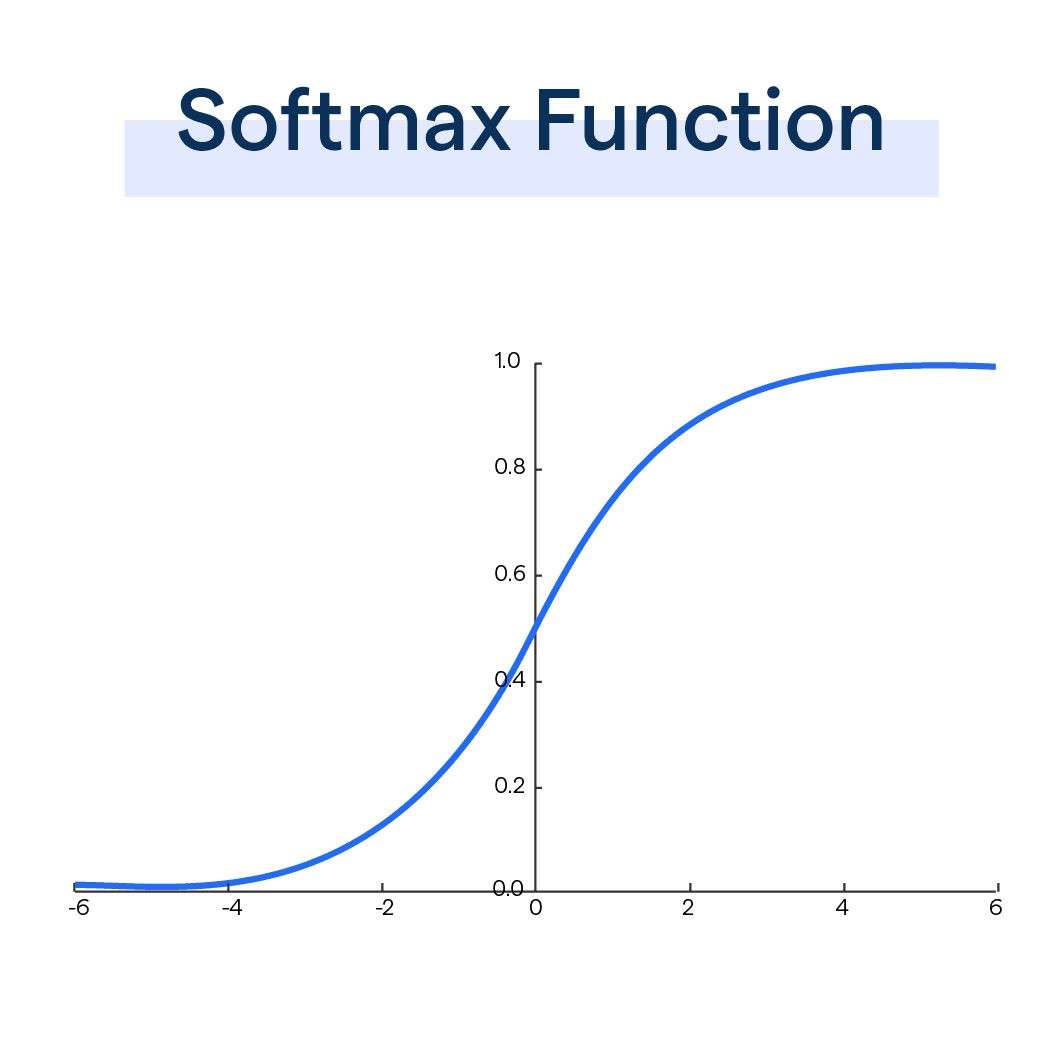

### scaled dot product attention implementation

In [ ]:
def attention_as_scaled_soft_dict(query, keys, values):
    length, head_dim = query.shape
    weights = query @ keys.transpose(-2, -1)  # kinda similarity between query and keys
    weights = F.softmax(weights / math.sqrt(head_dim), dim=-1)  # normalize weights to sum 1
    return weights @ values  # values weighted average


attention_as_scaled_soft_dict(query, keys, values)

tensor([[0.6698, 0.3302]])

# Self-attention

What if I do not know what I want to query?

Or worst, If I do not know which are the keys and values stored?

**Quick answer**:

I can learn it from the input?

- What am I looking for? Query
- What is stored? Keys
- What are the values of stored keys? Values

```python
query  = Linear(inputs)
keys   = Linear(inputs)
values = Linear(inputs)
```
As the query, keys and values are extracted from the same source (inputs), its called self-attention

## Implementation of self-attention

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.query = nn.Linear(embed_dim, head_dim, bias=False)
        self.key = nn.Linear(embed_dim, head_dim, bias=False)
        self.value = nn.Linear(embed_dim, head_dim, bias=False)

    def forward(self, embeddings):
        return attention_as_scaled_soft_dict(
            query=self.query(embeddings),
            keys=self.key(embeddings),
            values=self.value(embeddings)
        )

## Why do i need multi-head?

have you ever you are in a big supermarket wanting to buy some product but you don't know where is it stored?

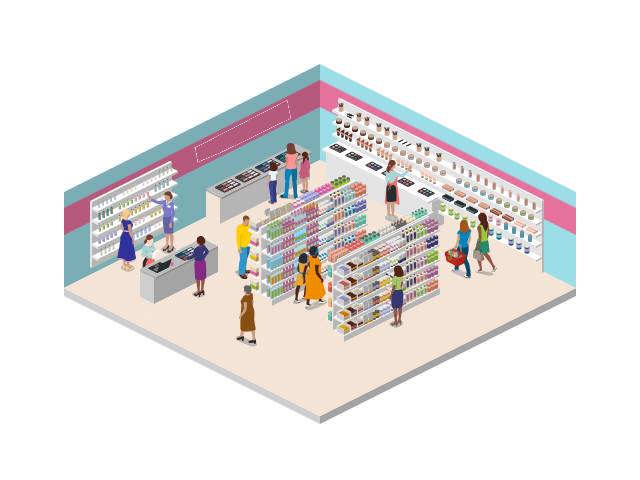

In this case, you usually ask for help. what is the usual answer to the question:

"Do you know where is the frozen chicken?"

probably is "have you seen in the frozen section? It is in the upper left corner"



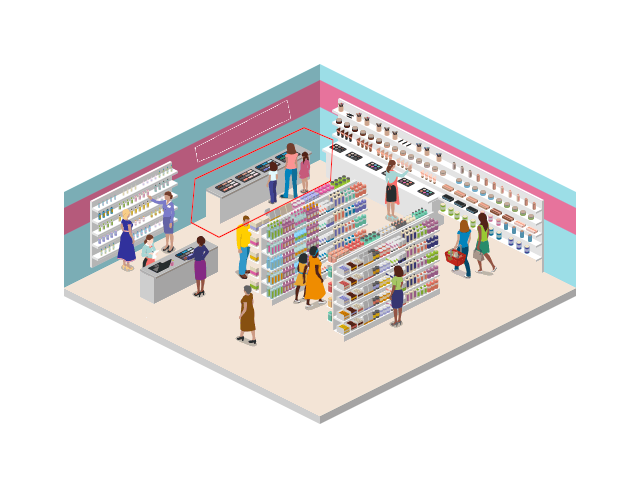

Probably, you will easily find what you need.

Then you now want a bread and ask again for help. the new answer could be:
"It is in the bakery section. It is in the upper part"

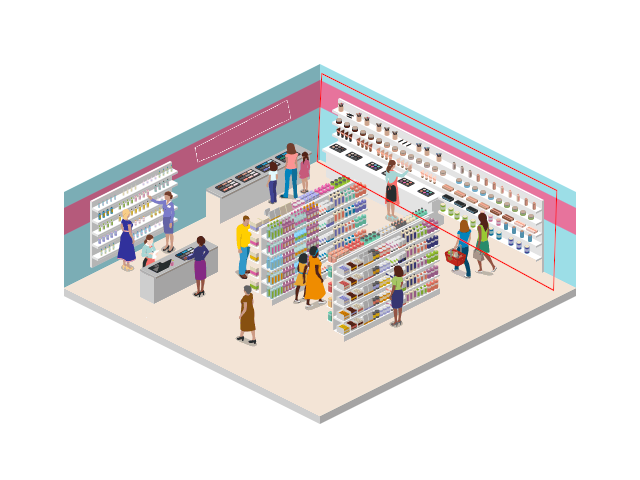

After see the section-wise market organization, you will start to look for sections instead of products. Then you can find easily what you want.

The same applies to our attention as soft dict. If you store information as section, it will be ease to find some key you are looking for. How to implement it?

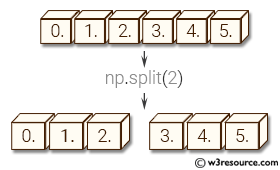

## Implementing multi-head self-attention

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, n_heads):
        super().__init__()

        self.heads = nn.ModuleList([
            SelfAttention(embedding_dim, head_dim = embedding_dim // n_heads)
            for _ in range(n_heads)
        ])

        assert embedding_dim % n_heads == 0, \
            "embedding dim should be divisible by n heads"

    def forward(self, embeddings):
        return torch.cat([head(embeddings) for head in self.heads], dim=-1)

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, n_heads):
        super().__init__()

        self.heads = nn.ModuleList([
            SelfAttention(embedding_dim, head_dim = embedding_dim // n_heads)
            for _ in range(n_heads)
        ])

        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(DROPOUT)

        assert embedding_dim % n_heads == 0, \
            "embedding dim should be divisible by n heads"

    def forward(self, embeddings):
        x = torch.cat([head(embeddings) for head in self.heads], dim=-1)
        x = self.proj(x)
        x = self.dropout(x)
        return x

Remember this point, we will increment the implementation later

# transformers

Archtecture:

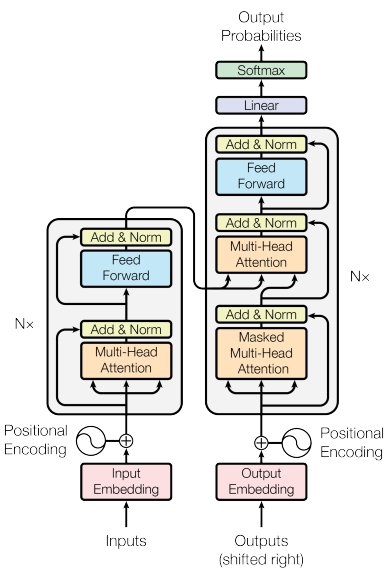

## intuition

Updating the meaning of words based on the relations of words


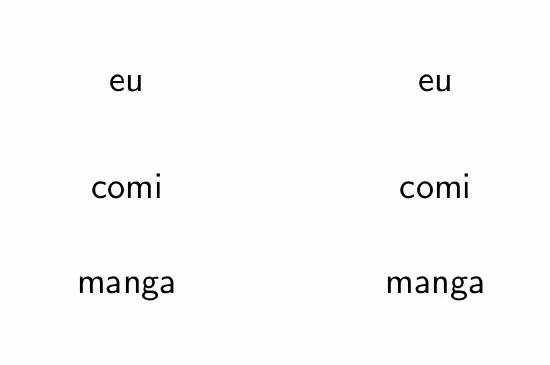

A second example of "manga"

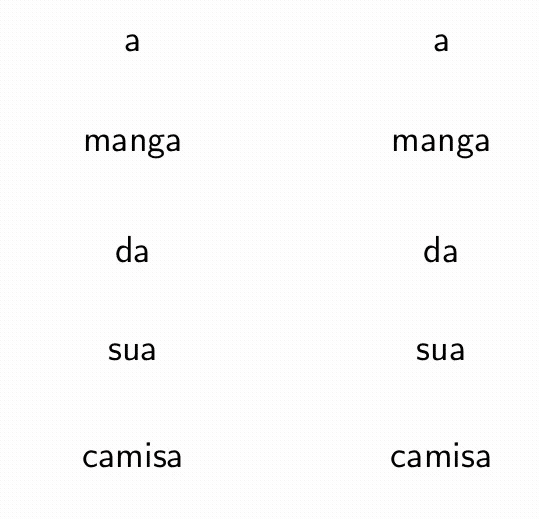

We can repeat it, updating the meaning of tokens based on the updated meaning

## how do they learn?

There is main two semi-supervised training methods:
 - Masked Language modeling
 - Causal language modeling

### Masked language modeling

 - Eu gosto de <font color='red'>\<mask\></font> mas não de cachorro



 - Eu gosto de <font color='red'>\<mask\></font> mas não de <font color='red'>cachorro</font>



 - Eu gosto de <font color='red'>gato</font> mas não de <font color='red'>cachorro</font>



```python
{
"gato": 0.87
"animais": 0.10
"rato": 0.01
}
```

It's similar when you don't get some word but you can infer it as you understand the rest of sentence

### Causal language modeling (predict next token)

- Eu amo ...

Have you ever completed someone else speech?

- Eu

- Eu amo

 - Eu amo a

- Eu amo a UnB

### Implementation of Masked self-attention

We will focus on causal language modeling used in generative models like GPT

What if you want to block certain keys in some query?

For instance, one wants to predict the next word in a sentence, so only previous words are allowed to be used as input:

```
I love <mask>
```
So we can modify the function `attention_as_scaled_soft_dict` to support an optional mask

this could emulate a causal mask, if we consider is each token and  each column is which tokens it has access

In [ ]:
torch.ones((10,10)).tril() # triangular lower

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
# inverting the logic (1 is where it should not have access)
torch.ones((10,10)).triu(diagonal=1) # triangular upper

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def masked_attention_as_scaled_soft_dict(query, keys, values, mask=None):
    _, n_queries, head_dim = query.shape
    n_keys = keys.size(-2)

    weights = query @ keys.transpose(-2, -1)  # kinda similarity between query and keys
    weights = weights / math.sqrt(head_dim)
    if mask is None:  # adds causal mask
        mask = torch.ones(n_queries, n_keys, dtype=torch.bool, device=device).triu(diagonal=1)

    # mitigate some relations
    weights.masked_fill_(mask, float("-inf"))
    weights = F.softmax(weights, dim=-1)  # normalize weights to sum 1
    return weights @ values  # values weighted average

In [ ]:
keys = torch.tensor([[[1.,0],[0, 1.]]], device=device)  # batch, length, head_dim
values = torch.tensor([[[1., 0], [0, 1.]]], device=device)
query = torch.tensor([[[1., 0.]]], device=device)

masked_attention_as_scaled_soft_dict(query, keys, values)

tensor([[[1., 0.]]], device='cuda:0')

### Implementing a transformer block

Redefining SelfAttention to use masked_attention_as_scaled_soft_dict

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.query = nn.Linear(embed_dim, head_dim, bias=False)
        self.key = nn.Linear(embed_dim, head_dim, bias=False)
        self.value = nn.Linear(embed_dim, head_dim, bias=False)

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, embeddings):
        return self.masked_attention_as_scaled_soft_dict(
            query=self.query(embeddings),
            keys=self.key(embeddings),
            values=self.value(embeddings)
        )

    def masked_attention_as_scaled_soft_dict(self, query, keys, values, mask=None):
        _, n_queries, head_dim = query.shape
        n_keys = keys.size(-2)

        weights = query @ keys.transpose(-2, -1)  # kinda similarity between query and keys
        weights = weights / math.sqrt(head_dim)
        if mask is None:  # adds causal mask
            mask = torch.ones(n_queries, n_keys, dtype=torch.bool, device=device).triu(diagonal=1)

        # mitigate some relations
        weights.masked_fill_(mask, float("-inf"))
        weights = F.softmax(weights, dim=-1)  # normalize weights to sum 1
        weights = self.dropout(weights)
        return weights @ values  # values weighted average

Updating relations between tokens

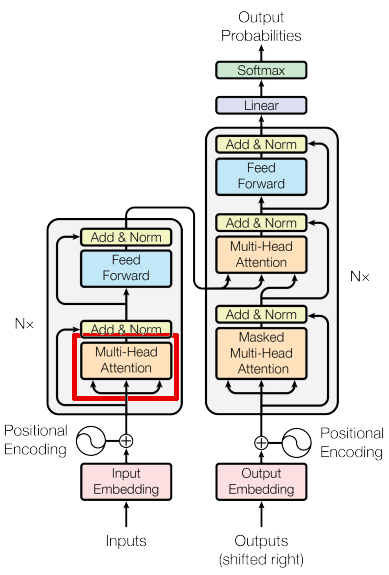

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, n_heads=8):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embedding_dim, n_heads)

    def forward(self, embeddings):
        return self.attention(embeddings)

Residual connection -> The relation between tokens just says the change in the meaning

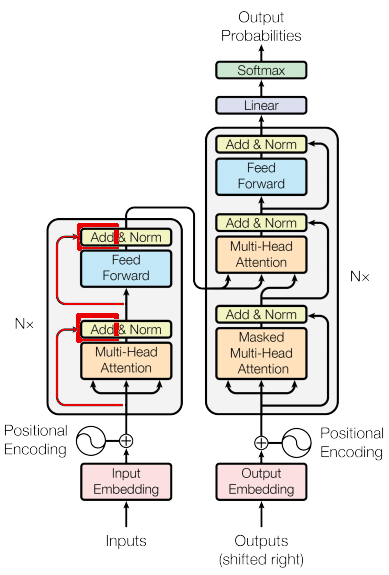

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, n_heads=8):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embedding_dim, n_heads)

    def forward(self, embeddings):
        return embeddings + self.attention(embeddings)

Look the local information (what happened to each token)

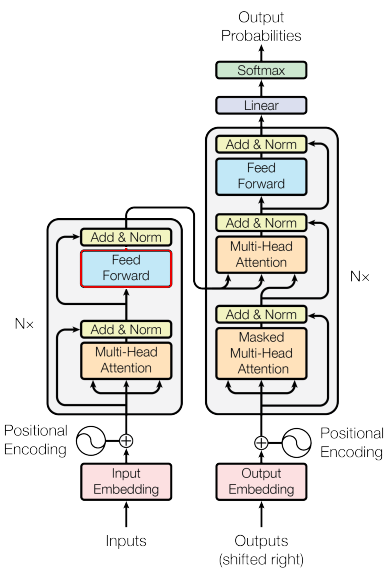

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, n_heads=8, hidden_dim=1024):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embedding_dim, n_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(DROPOUT),
        )

    def forward(self, embeddings):
        x = embeddings + self.attention(embeddings)
        return x + self.feed_forward(x)

Adding some normalizations

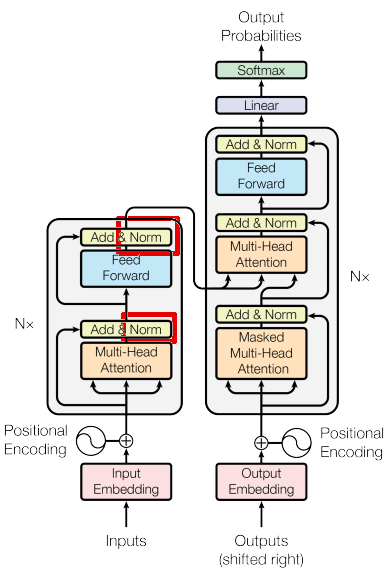

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, n_heads=8, hidden_dim=1024):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embedding_dim, n_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(DROPOUT),
        )
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)


    def forward(self, embeddings):
        x = self.norm1(embeddings + self.attention(embeddings))
        return self.norm1(x + self.feed_forward(x))

repeat it n times (update the meaning of words based on updated meanings)

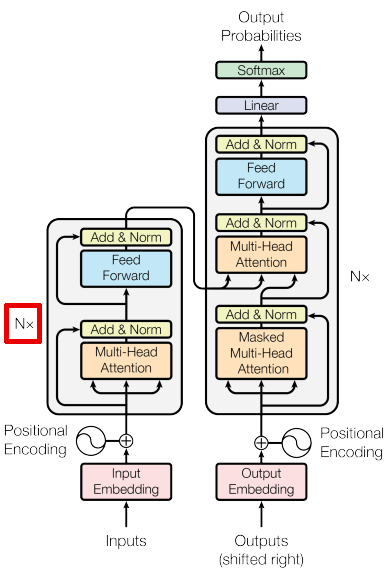

In [ ]:
class GPTLike(nn.Module):
    def __init__(self, n_layers, vocab_size, CONTEXT_LENGTH, embedding_dim,
                 n_heads=8, hidden_dim=1024):
        super().__init__()

        self.tokens_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embeddings = nn.Embedding(CONTEXT_LENGTH, embedding_dim)

        self.transformer = nn.Sequential(*[
            TransformerBlock(embedding_dim, n_heads, hidden_dim)
            for _ in range(n_layers)
        ])

        self.lm_head = nn.Linear(embedding_dim, vocab_size)


    def forward(self, input_ids):
        tokens_embeddings = self.tokens_embeddings(input_ids)
        positional_embeddings = self.position_embeddings(
            torch.arange(input_ids.size(-1), device=device)
        )
        embeddings = tokens_embeddings + positional_embeddings
        x = self.transformer(embeddings)
        logits = self.lm_head(x)

Adding training and generation support

In [ ]:
class GPTLike(nn.Module):
    def __init__(self, n_layers, vocab_size, CONTEXT_LENGTH, embedding_dim,
                 n_heads=8, hidden_dim=1024):

        super().__init__()
        self.tokens_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embeddings = nn.Embedding(CONTEXT_LENGTH, embedding_dim)

        self.transformer = nn.Sequential(*[
            TransformerBlock(embedding_dim, n_heads, hidden_dim)
            for _ in range(n_layers)
        ])

        self.lm_head = nn.Linear(embedding_dim, vocab_size, bias=False)
        # self.lm_head.weight.data = self.tokens_embeddings.weight.data


    def forward(self, input_ids, targets=None):
        tokens_embeddings = self.tokens_embeddings(input_ids)
        positional_embeddings = self.position_embeddings(
            torch.arange(input_ids.size(-1), device=device)
        )
        embeddings = tokens_embeddings + positional_embeddings
        x = self.transformer(embeddings)
        logits = self.lm_head(x)

        if targets is None:
            loss = None

        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad
    def generate(self, ids, max_new_tokens):
        self.eval()

        for _ in range(max_new_tokens):
            ids = ids[:, -CONTEXT_LENGTH:]
            logits, loss = model(ids)
            logits = logits[:,-1,:] # get last token prediction
            probs = F.softmax(logits, dim=-1)
            # get most probable token
            next_ids = torch.argmax(probs, dim=-1, keepdims=True)
            # next_ids = torch.multinomial(probs, num_samples=1)
            ids = torch.cat((ids, next_ids), dim=1)

        return ids

In [ ]:
def get_batch(split):
    data = dataset[split]
    ix = torch.randint(len(data) - CONTEXT_LENGTH, (BATCH_SIZE, 1))
    x = torch.stack([data[i: i+CONTEXT_LENGTH] for i in ix])
    y = torch.stack([data[i+1:i+CONTEXT_LENGTH+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()

    for split in ["train", "val"]:
        losses = torch.zeros(10)
        for k in range(10):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train()
    return out


In [ ]:
from tqdm.notebook import tqdm


def train(model, tokenizer):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    for iter in tqdm(range(MAX_ITERS)):
        if iter % EVAL_ITERS ==0:
            losses = estimate_loss()
            print(f"step {iter: >4}: train loss {losses['train']:.4f},")

        Xb, yb = get_batch("train")
        logits, loss = model(Xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [ ]:
import re
from collections import defaultdict


class Tokenizer:
    def __init__(self, vocab_size):
        self.occurrences = defaultdict(int)
        self.vocab_size = vocab_size
        self.vocab = {}

    @staticmethod
    def split(text):
        text = re.sub(r'\s+', ' ', text.lower())
        return [token for token in re.split(r'([\.\?\!,\s\-"\']+)', text)
                if token.strip()]

    def fit(self, text):
        tokens = self.split(text)
        for token in tokens:
            self.occurrences[token] += 1

        occurrences = sorted(self.occurrences.items(), key=lambda x: x[1])
        self.vocab = {
            token: i + 1
            for i, (token,  _) in enumerate(occurrences[-(self.vocab_size-1):])
        }

        self.inv_vocab = ['<UNK>'] + list(self.vocab)


    def __call__(self, text):
        return [self.vocab.get(token, 0) for token in self.split(text)]

    def decode(self, ids):
        return " ".join([self.inv_vocab[id] for id in ids
                         if id < len(self.inv_vocab)])


In [ ]:
text = 'eu,sou\n joao'

tokenizer = Tokenizer(5)
tokenizer.fit(text)
tokenizer.decode(tokenizer(text))

'eu , sou joao'

In [ ]:
tokenizer.vocab

{'eu': 1, ',': 2, 'sou': 3, 'joao': 4}

In [ ]:
with open("domCasmurro.txt") as file:
    text = file.read()

tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit(text)
print('Vocab size:', len(tokenizer.vocab))

data = torch.tensor(tokenizer(text), device=device)
len(data)

Vocab size: 9550


80554

In [ ]:
dataset = {
    "train": data[1000:],
    "val": data[:1000]
}

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model = GPTLike(N_LAYERS, VOCAB_SIZE, CONTEXT_LENGTH, EMBEDDING_DIM, N_HEADS,
                HIDDEN_DIM).to(device)
print(f'Number of parameters: {count_parameters(model):,.0f}')


Number of parameters: 23,271,936


In [ ]:
input_ids = torch.tensor([tokenizer("capitu sorriu")], device=device)
tokenizer.decode(model.generate(input_ids, 64).tolist()[0])

'capitu sorriu esconderijo simples; estúpido concluí execro fixar virtude chumbo ótima faltasse dissimular intensos desfechou trecho agarreime veremos tem nadas virtude falecera saltinhos furiosas mudaram colcha bastaria infinitas atenta cxxxix explico cantava compleição ativer prometida bailes ressentimentos espectador oh'

In [ ]:
train(model, tokenizer)

  0%|          | 0/2000 [00:00<?, ?it/s]

step    0: train loss 9.8393,
step  200: train loss 4.9795,
step  400: train loss 3.9495,
step  600: train loss 2.8756,
step  800: train loss 1.6694,
step 1000: train loss 0.7341,
step 1200: train loss 0.3264,
step 1400: train loss 0.1992,
step 1600: train loss 0.1542,
step 1800: train loss 0.1321,


In [ ]:
input_ids = torch.tensor([tokenizer("capitu sorriu")], device=device)
tokenizer.decode(model.generate(input_ids, 64).tolist()[0])

'capitu sorriu ,  e respondeu - me com amor .  quis tapar - me que era a casa dele ,  e passar aqui mesmo valeu a narração por ser até que ouvi os batedores e o piquete de cavalaria; é o imperador !  toda a gente chegava às janelas para vê - lo passar ,  mas não passava ,  o coche parava à nossa porta , '